In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stat
from scipy.stats import zscore

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [3]:
#importing data
Staller5ADlib = pd.read_csv("data/Staller2022_5AD_library.csv")
Staller_p53AD = pd.read_csv("data/Staller2022_p53AD.csv")
Staller_predictedAD = pd.read_csv("data/Staller2022_predicted_AD.csv")
ChoiADs = pd.read_csv("data/tf_effectordomains.csv")

aa_length_cutoff = 20

ChoiADs = ChoiADs[ChoiADs["Domain type"] == "AD"]
ChoiADs = ChoiADs.set_index("Effector domain ID")[["Sequence", "Activity (H, M or L)"]]
ChoiADs = ChoiADs[[len(x) > aa_length_cutoff for x in ChoiADs["Sequence"]]]


Staller5ADlib_zscores = Staller5ADlib[["Biological_Replicate_1_Activity", "Biological_Replicate_2_Activity", "Biological_Replicate_3_Activity", "Biological_Replicate_4_Activity"]].apply(zscore)
Staller5ADlib["Activity_Zscore_mean"] = Staller5ADlib_zscores.mean(axis=1)

Staller5ADlib_select = Staller5ADlib[["ADseq", "Activity_Zscore_mean"]].rename({"ADseq": "Sequence"}, axis=1)
Staller5ADlib_select = Staller5ADlib_select[[len(x) >= aa_length_cutoff for x in Staller5ADlib_select["Sequence"]]]

Stallerp53AD_select = Staller_p53AD[["ADseq", "Activity_Zscore_mean", "Activity_Zscore_SEM"]].rename({"ADseq": "Sequence"}, axis=1)
Stallerp53AD_select = Stallerp53AD_select[[len(x) >= aa_length_cutoff for x in Stallerp53AD_select["Sequence"]]]

Staller_predictedAD_select = Staller_predictedAD[["ProteinRegionSeq", "Activity_Zscore_mean", "Activity_Zscore_SEM"]].rename({"ProteinRegionSeq": "Sequence"}, axis=1)
Staller_predictedAD_select = Staller_predictedAD_select[[len(x) >= aa_length_cutoff for x in Staller_predictedAD_select["Sequence"]]]

choiAD_coA_finches = pd.read_csv("helperdata/ChoiADs_coA.csv", index_col=0)
staller5libAD_coA_finches = pd.read_csv("helperdata/Staller5libADs_coA.csv", index_col=0)
stallerP53AD_coA_finches = pd.read_csv("helperdata/StallerP53ADs_coA.csv", index_col=0)
stallerpredictedAD_coA_finches = pd.read_csv("helperdata/StallerPredictedADs_coA.csv", index_col=0)

def activity_category(finchesresult_df, AD_df, activitylabel):
    with_activity = finchesresult_df.merge(AD_df[[activitylabel]], left_on="Prot1", right_index=True, how="left")
    return with_activity

choiAD_coA_finches_activity = activity_category(choiAD_coA_finches, ChoiADs, "Activity (H, M or L)")
staller5libAD_coA_finches_activity = activity_category(staller5libAD_coA_finches, Staller5ADlib_select, "Activity_Zscore_mean")
stallerP53AD_coA_finches_activity = activity_category(stallerP53AD_coA_finches, Stallerp53AD_select, "Activity_Zscore_mean")
stallerPredictedADs_coA_finches_activity = activity_category(stallerpredictedAD_coA_finches, Staller_predictedAD_select, "Activity_Zscore_mean")

coAs = pd.read_csv("helperdata/coAs.csv", index_col=0)

<Axes: xlabel='Prot2', ylabel='Prot1'>

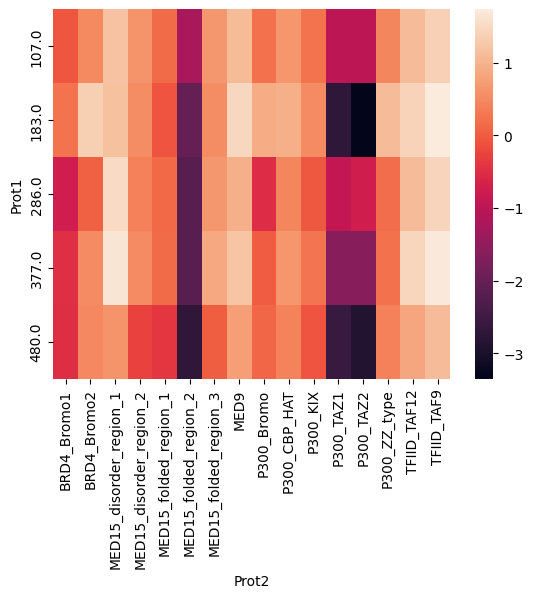

In [265]:
Staller5AD_WT_index = Staller5ADlib[Staller5ADlib["WT"] == True].index.to_list()
sns.heatmap(staller5libAD_coA_finches_activity.loc[Staller5AD_WT_index].pivot(index = "Prot1", columns="Prot2", values="Total e (mf)"))

In [129]:
coAs.loc["MED15_folded_region_2"]["Sequence"]

'ALQQQQQQQQFQQQQQAALQQQQQQQQQQQFQAQQSAMQQQFQAVVQQQQQLQQQQQQQQHLIKLHHQNQQQIQQQQQQLQRIAQLQLQQQQQ'

In [4]:
#calculate correlation for each domain
def correlation_with_activity(df, activity_label, bydomain):
    if bydomain:
        outputdf = pd.DataFrame(index = coAs.index.to_list())
        for quantvar in ["Attractive e (mf)", "Repulsive e (mf)", "Total e (mf)", "Attractive e (cf)", "Repulsive e (cf)", "Total e (cf)"]:
            selectonly = df[["Prot2", quantvar, activity_label]].dropna()
            selectonly = selectonly.groupby("Prot2").agg(list)
            if activity_label != quantvar:
                outputdf[quantvar + " Pearson R"] = selectonly.apply(lambda row: stat.pearsonr(row[activity_label], row[quantvar])[0], axis=1)
                outputdf[quantvar + " Spearman R"] = selectonly.apply(lambda row: stat.spearmanr(row[activity_label], row[quantvar])[0], axis=1)
    else:
        outputdf = df.set_index(["Prot1", "Prot2"]).corr()
    return outputdf

In [5]:
#Check if any domains show correlation between interaction and activity: Answer - No
staller5lib_corrs = correlation_with_activity(staller5libAD_coA_finches_activity, "Activity_Zscore_mean", True)
stallerP53AD_corrs = correlation_with_activity(stallerP53AD_coA_finches_activity, "Activity_Zscore_mean", True)
stallerPredictedADs_corrs = correlation_with_activity(stallerPredictedADs_coA_finches_activity, "Activity_Zscore_mean", True)

staller5lib_corrs_highest = abs(staller5lib_corrs).max().max()
stallerP53AD_corrs_highest = abs(stallerP53AD_corrs).max().max()
stallerPredictedADs_corrs_highest = abs(stallerPredictedADs_corrs).max().max()

if staller5lib_corrs_highest >= 0.6:
    print("5Lib", abs(staller5lib_corrs).stack().idxmax(), staller5lib_corrs_highest)
if stallerP53AD_corrs_highest >= 0.6:
    print("P53", abs(stallerP53AD_corrs).stack().idxmax(), stallerP53AD_corrs_highest)
if stallerPredictedADs_corrs_highest >= 0.6:
    print("Predicted", abs(stallerPredictedADs_corrs).stack().idxmax(), stallerPredictedADs_corrs_highest)

/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_53008/2349159013.py:2: FutureWarning: The provided callable <function mean at 0x12081d6c0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  mean_interaction_df = df.drop(["Prot1", activity_label], axis=1).groupby("Prot2").agg(aggfunc)


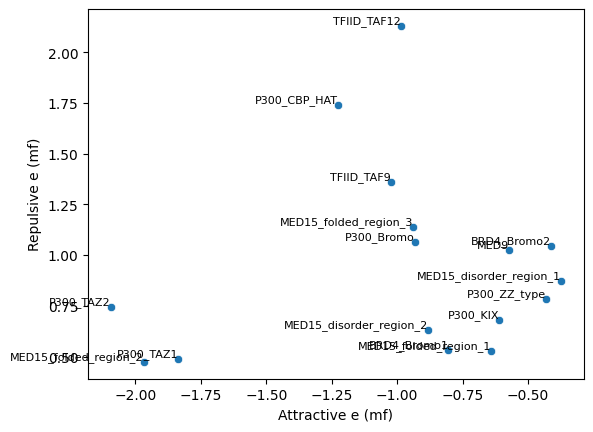

/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_53008/2349159013.py:2: FutureWarning: The provided callable <function mean at 0x12081d6c0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  mean_interaction_df = df.drop(["Prot1", activity_label], axis=1).groupby("Prot2").agg(aggfunc)


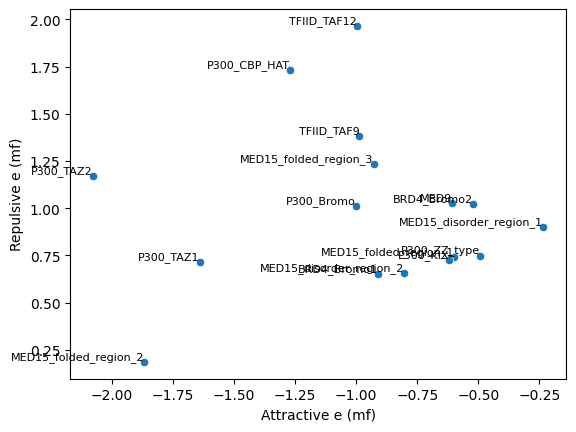

/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_53008/2349159013.py:2: FutureWarning: The provided callable <function mean at 0x12081d6c0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  mean_interaction_df = df.drop(["Prot1", activity_label], axis=1).groupby("Prot2").agg(aggfunc)


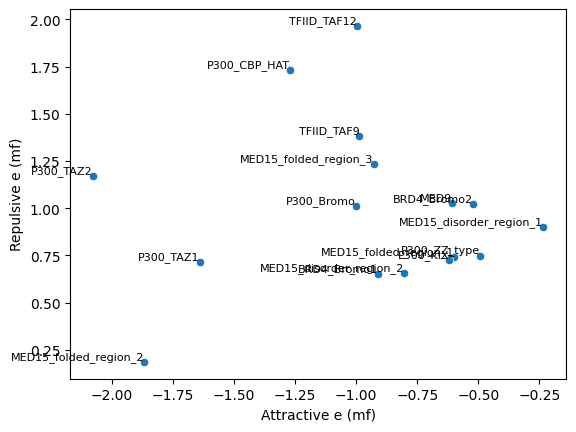

/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_53008/2349159013.py:2: FutureWarning: The provided callable <function mean at 0x12081d6c0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  mean_interaction_df = df.drop(["Prot1", activity_label], axis=1).groupby("Prot2").agg(aggfunc)


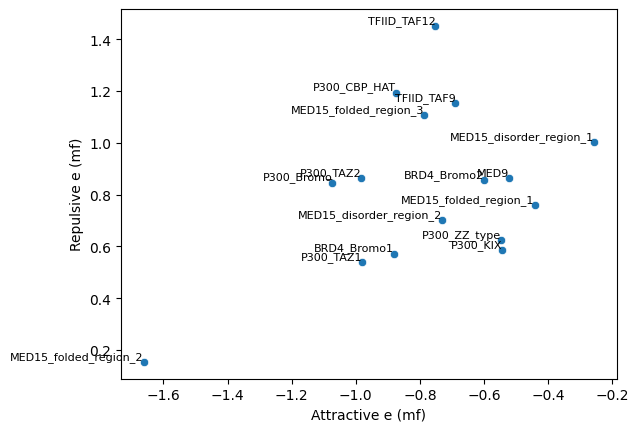

In [6]:
def plot_interaction_by_group(df, aggfunc, activity_label):
    mean_interaction_df = df.drop(["Prot1", activity_label], axis=1).groupby("Prot2").agg(aggfunc)
    mean_interaction_df

    x_label = "Attractive e (mf)"
    y_label = "Repulsive e (mf)"

    sns.scatterplot(mean_interaction_df, x = x_label, y = y_label)

    for i in range(len(mean_interaction_df)):
        plt.text(mean_interaction_df[x_label].iloc[i], mean_interaction_df[y_label].iloc[i], mean_interaction_df.index[i],
                fontsize=8, ha='right', va='bottom')
    plt.show()

plot_interaction_by_group(staller5libAD_coA_finches_activity, np.mean, activity_label = "Activity_Zscore_mean")
plot_interaction_by_group(stallerP53AD_coA_finches_activity, np.mean, activity_label = "Activity_Zscore_mean")
plot_interaction_by_group(stallerPredictedADs_coA_finches_activity, np.mean, activity_label = "Activity_Zscore_mean")
plot_interaction_by_group(choiAD_coA_finches_activity, np.mean, activity_label = "Activity (H, M or L)")


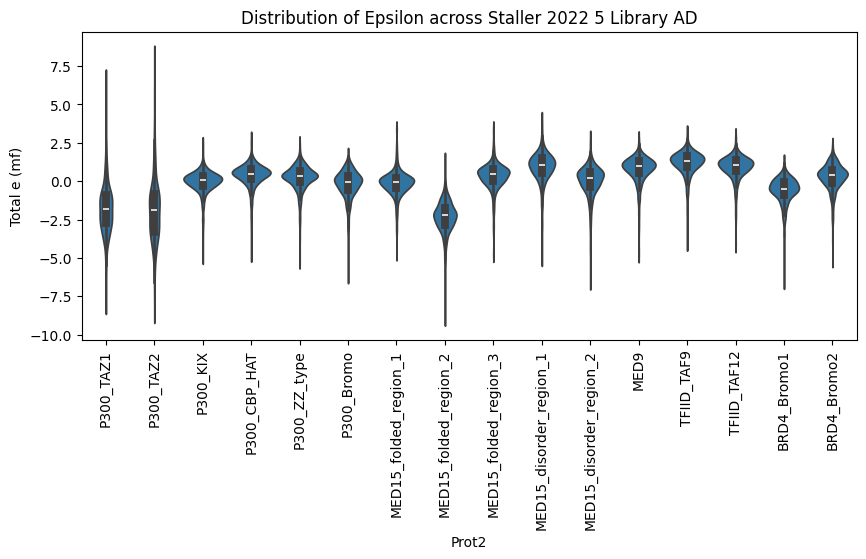

<Figure size 640x480 with 0 Axes>

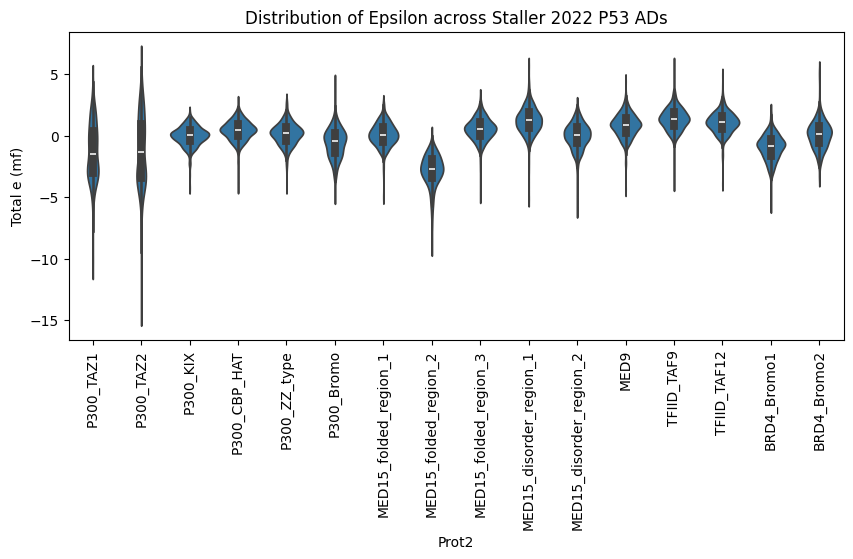

<Figure size 640x480 with 0 Axes>

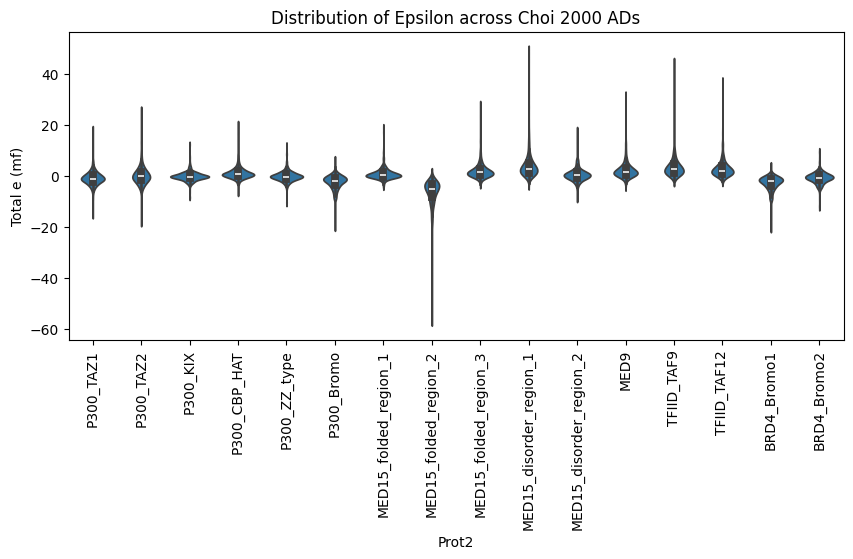

<Figure size 640x480 with 0 Axes>

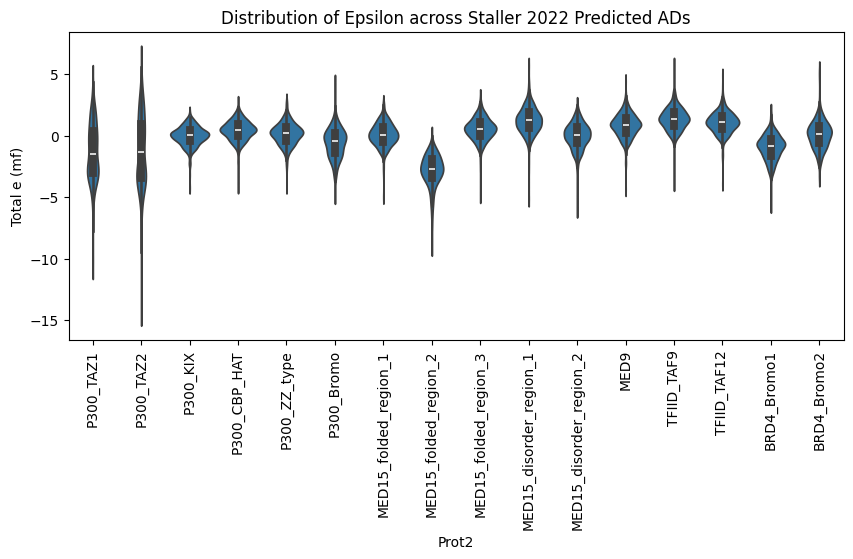

<Figure size 640x480 with 0 Axes>

In [126]:
plt.figure(figsize=(10, 4))
sns.violinplot(staller5libAD_coA_finches_activity.reset_index(), x = "Prot2", y = "Total e (mf)")
plt.xticks(rotation=90)
plt.title("Distribution of Epsilon across Staller 2022 5 Library AD")
plt.savefig("figures/AD_coA_epsilon_dist_5Lib_ADs.png", bbox_inches = "tight")
plt.show()
plt.clf()

plt.figure(figsize=(10, 4))
sns.violinplot(stallerP53AD_coA_finches_activity.reset_index(), x = "Prot2", y = "Total e (mf)")
plt.xticks(rotation=90)
plt.title("Distribution of Epsilon across Staller 2022 P53 ADs")
plt.savefig("figures/AD_coA_epsilon_dist_P53_ADs.png", bbox_inches = "tight")
plt.show()
plt.clf()

plt.figure(figsize=(10, 4))
sns.violinplot(choiAD_coA_finches_activity.reset_index(), x = "Prot2", y = "Total e (mf)")
plt.xticks(rotation=90)
plt.title("Distribution of Epsilon across Choi 2000 ADs")
plt.savefig("figures/AD_coA_epsilon_dist_Choi2000_ADs.png", bbox_inches = "tight")
plt.show()
plt.clf()

plt.figure(figsize=(10, 4))
sns.violinplot(stallerPredictedADs_coA_finches_activity.reset_index(), x = "Prot2", y = "Total e (mf)")
plt.xticks(rotation=90)
plt.title("Distribution of Epsilon across Staller 2022 Predicted ADs")
plt.savefig("figures/AD_coA_epsilon_dist_Predicted_ADs.png", bbox_inches = "tight")
plt.show()
plt.clf()

---
# Look at motifs across ADs and CoAs

In [257]:
import regex as re
from Bio.SeqUtils.ProtParam import ProteinAnalysis

In [242]:
def count_patterns(df, sequence_col="Sequence"):
    regexterms = ["[WFYL]", "[DE]" , "[SPQ]", "[Q]", "[RHK]", "[STNQ]", "[FYW]", "[AVILM]"]

    def get_regex_counts(sequence):
        regexdict = {}
        for regexterm in regexterms:
            regexdict[regexterm] = len(re.findall(regexterm, sequence))
        return regexdict

    metrics_df = df[sequence_col].apply(get_regex_counts).apply(pd.Series)
    return df.join(metrics_df)

def compute_protein_metrics(df, sequence_col="Sequence", pH=7.0):
    def analyze_sequence(seq):
        protein = ProteinAnalysis(seq)
        composition = protein.count_amino_acids()

        d1 =  {
            "Net Charge at pH {:.1f}".format(pH): protein.charge_at_pH(pH),
            "Isoelectric Point (pI)": protein.isoelectric_point(),
            "Hydrophobicity (GRAVY)": protein.gravy(),
            "Instability Index": protein.instability_index(),
        }
        d1.update(composition)
        return d1
    
    metrics_df = df[sequence_col].apply(analyze_sequence).apply(pd.Series)
    return df.join(metrics_df)


def aa_composition(df, sequence_col="Sequence"):
    aa_comp_df = df[sequence_col].apply(lambda x: (ProteinAnalysis(x).get_amino_acids_percent())).apply(pd.Series)
    return df.join(aa_comp_df)

In [234]:
Staller5ADlib_select_features = compute_protein_metrics(count_patterns(Staller5ADlib_select))
Staller5ADlib_select_features

/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_53008/1802710124.py:10: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  metrics_df = df[sequence_col].apply(get_regex_counts).apply(pd.Series)
/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_53008/1802710124.py:27: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  metrics_df = df[sequence_col].apply(analyze_sequence).apply(pd.Series)


,Sequence,Activity_Zscore_mean,[WFYL],[DE],[SPQ],[Q],[RHK],[STNQ],[FYW],[AVILM],...,M,N,P,Q,R,S,T,V,W,Y
0,ALLGQSMAASGLPQLTSYACAVNAPIQGSANLLQGAALLAALAQVN,-0.569574,10,0,11,5,0,13,1,25,...,1.0,3.0,2.0,5.0,0.0,4.0,1.0,2.0,0.0,1.0
1,ALLGQSMDESGLPQLTSYDCEVNAPIQGSANLLQGEELLAALDQVN,0.694728,10,7,11,5,0,13,1,18,...,1.0,3.0,2.0,5.0,0.0,4.0,1.0,2.0,0.0,1.0
2,DDDIDLPMDPRDLDDLMDFGDDGEGAEPDAGGDFEDLDFDMELDDE,-0.324962,8,23,3,0,1,0,3,11,...,3.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,DDDIDLPMDPRDLDDLMDFGDDGEGAEPSAGGQFESLTFDMELTSE,-0.274816,8,17,7,1,1,6,3,11,...,3.0,0.0,3.0,1.0,1.0,3.0,2.0,0.0,0.0,0.0
4,DDFIDEEVLMDLVIEMGLDRIKELPELWLGDDEFDFMDD,2.004356,10,16,1,0,2,0,4,14,...,3.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,TKFIKKKVLMSLVIKMGLKRIKELPELWLGQNEFDFMTD,-0.383847,10,5,3,1,8,5,4,14,...,3.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,0.0
521,TKFIKKKVLMSLVIKMGLKRIKKLPKLWLGQNKFKFMTK,-0.491240,10,0,3,1,13,5,4,14,...,3.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,0.0
522,TRFIRRRVLMSLVIRMGLRRIKELPELWLGQNEFDFMTD,-0.632829,10,5,3,1,8,5,4,14,...,3.0,1.0,1.0,1.0,7.0,1.0,2.0,2.0,1.0,0.0
523,TRFIRRRVLMSLVIRMGLRRIKRLPRLWLGQNRFRFMTR,-0.486277,10,0,3,1,13,5,4,14,...,3.0,1.0,1.0,1.0,12.0,1.0,2.0,2.0,1.0,0.0


In [226]:
coAS_features = compute_protein_metrics(count_patterns(coAs))
coAS_features

/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_53008/3385297266.py:10: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  metrics_df = df[sequence_col].apply(get_regex_counts).apply(pd.Series)
/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_53008/3385297266.py:27: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  metrics_df = df[sequence_col].apply(analyze_sequence).apply(pd.Series)


,Sequence,[WFYL],[DE],[SPQ],[Q],[RHK],[STNQ],[FYW],[AVILM],Net Charge at pH 7.0,...,M,N,P,Q,R,S,T,V,W,Y
P300_TAZ1,DPEKRKLIQQQLVLLLHAHKCQRREQANGEVRQCNLPHCRTMKNVL...,10,5,18,9,21,22,1,23,8.372995,...,2.0,5.0,4.0,9.0,7.0,5.0,3.0,5.0,1.0,0.0
P300_TAZ2,GDSRRLSIQRCIQSLVHACQCRNANCSLPSCQKMKRVVQHTKGCKR...,8,2,16,7,18,19,2,20,11.974966,...,1.0,5.0,4.0,7.0,6.0,5.0,2.0,4.0,0.0,1.0
P300_KIX,GIRKQWHEDITQDLRNHLVHKLVQAIFPTPDPAALKDRRMENLVAY...,15,13,8,4,17,11,7,27,0.130075,...,2.0,4.0,3.0,4.0,6.0,1.0,2.0,4.0,1.0,5.0
P300_CBP_HAT,KFSAKRLPSTRLGTFLENRVNDFLRRQNHPESGEVTVRVVHASDKT...,66,56,62,11,71,71,36,95,3.804537,...,9.0,15.0,24.0,11.0,23.0,27.0,18.0,23.0,4.0,13.0
P300_ZZ_type,RFVYTCNECKHHVETRWHCTVCEDYDLCITCYNTKNHDHKMEKLGLGLD,9,8,0,0,11,8,5,9,-1.851541,...,1.0,3.0,0.0,0.0,2.0,0.0,5.0,3.0,1.0,3.0
P300_Bromo,RQDPESLPFRQPVDPQLLGIPDYFDIVKSPMDLSTIKRKLDTGQYQ...,18,10,17,6,9,16,11,18,-1.234352,...,2.0,3.0,7.0,6.0,5.0,4.0,3.0,4.0,3.0,5.0
MED15_folded_region_1,MDVSGQETDWRSTAFRQKLVSQIEDAMRKAGVAHSKSSKDMESHVF...,10,10,11,3,16,15,5,23,1.859965,...,3.0,1.0,0.0,3.0,6.0,8.0,3.0,5.0,1.0,1.0
MED15_folded_region_2,ALQQQQQQQQFQQQQQAALQQQQQQQQQQQFQAQQSAMQQQFQAVV...,11,0,63,62,5,64,3,21,2.056388,...,1.0,1.0,0.0,62.0,1.0,1.0,0.0,2.0,0.0,0.0
MED15_folded_region_3,QQYLDKLKQLSKYIEPLRRMINKIDKNEDRKKDLSKMKSLLDILTD...,48,27,62,16,41,56,13,83,7.308777,...,5.0,10.0,28.0,16.0,14.0,18.0,12.0,16.0,3.0,6.0
MED15_disorder_region_1,KKSQASVSDPMNALQSLTGGPAAGAAGIGMPPRGPGQSLGGMGSLG...,7,1,32,10,4,27,0,29,1.846389,...,7.0,1.0,11.0,10.0,1.0,11.0,5.0,4.0,0.0,0.0


In [ ]:
sns.scatterplot(Staller5ADlib_select, x = )

/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_53008/2382295950.py:32: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  aa_comp_df = df[sequence_col].apply(lambda x: (ProteinAnalysis(x).get_amino_acids_percent())).apply(pd.Series)


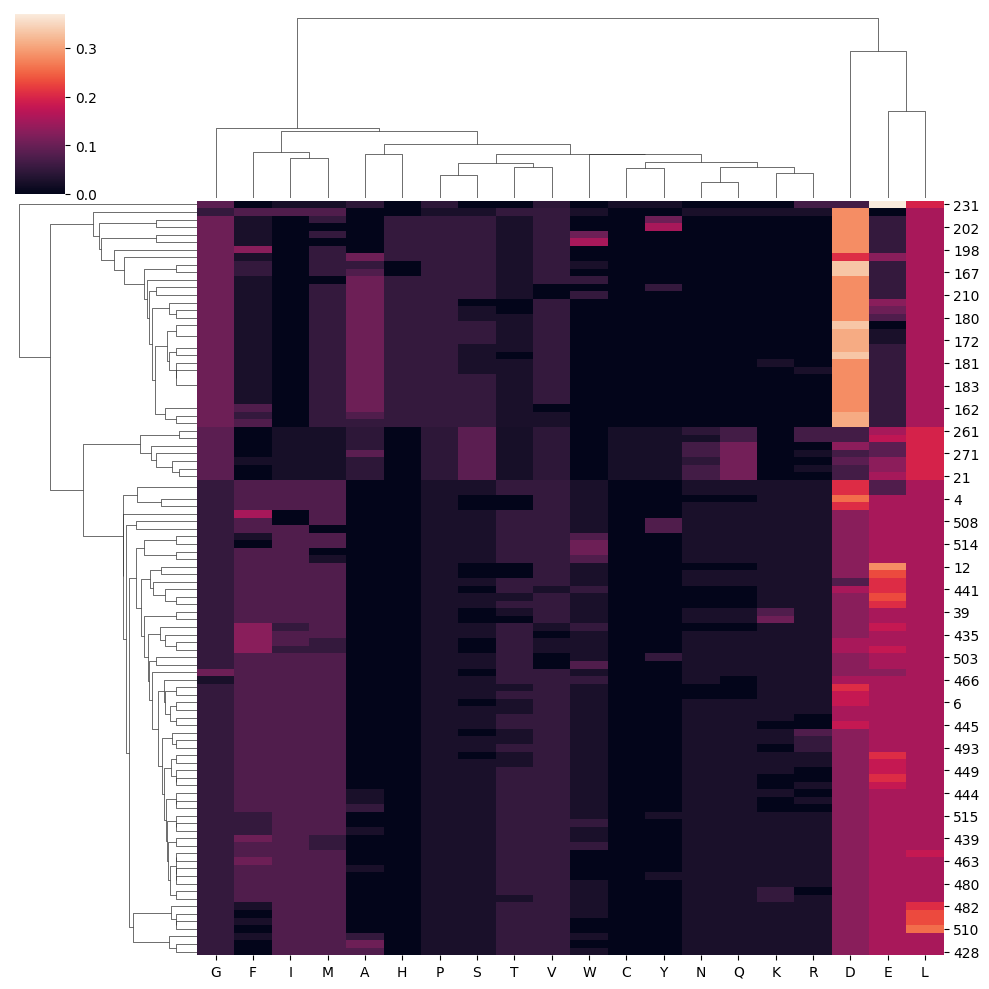

In [256]:
Staller5ADlib_select_top100 = Staller5ADlib_select.sort_values("Activity_Zscore_mean", ascending=False)[:100]
sns.clustermap(aa_composition(Staller5ADlib_select_top100).drop(["Sequence", "Activity_Zscore_mean"], axis=1))

/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_53008/2382295950.py:32: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  aa_comp_df = df[sequence_col].apply(lambda x: (ProteinAnalysis(x).get_amino_acids_percent())).apply(pd.Series)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


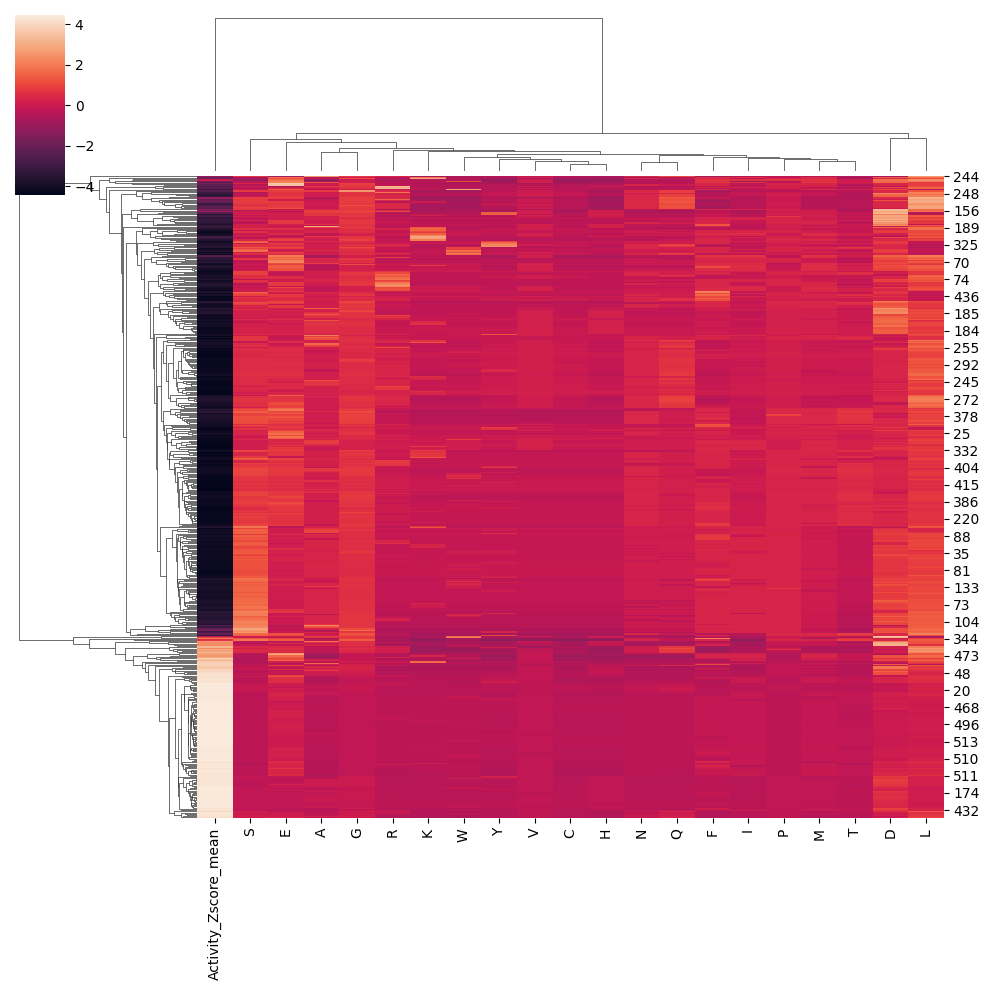

In [251]:
sns.clustermap(aa_composition(Staller5ADlib_select).drop("Sequence", axis=1).apply(zscore, axis=1))

/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_53008/2382295950.py:32: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  aa_comp_df = df[sequence_col].apply(lambda x: (ProteinAnalysis(x).get_amino_acids_percent())).apply(pd.Series)


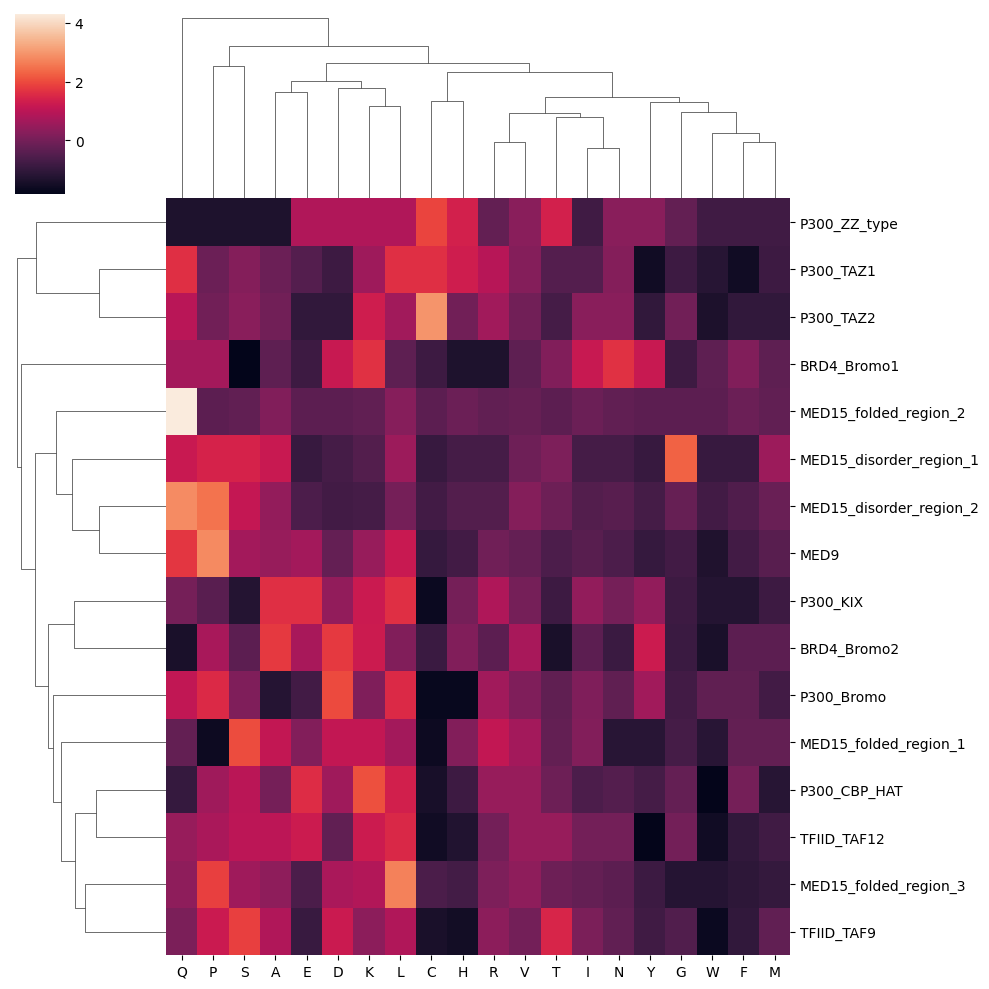

In [250]:
sns.clustermap(aa_composition(coAs).drop("Sequence", axis=1).apply(zscore, axis=1))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInp

Text(314.68686868686865, 0.5, 'Coactivator')

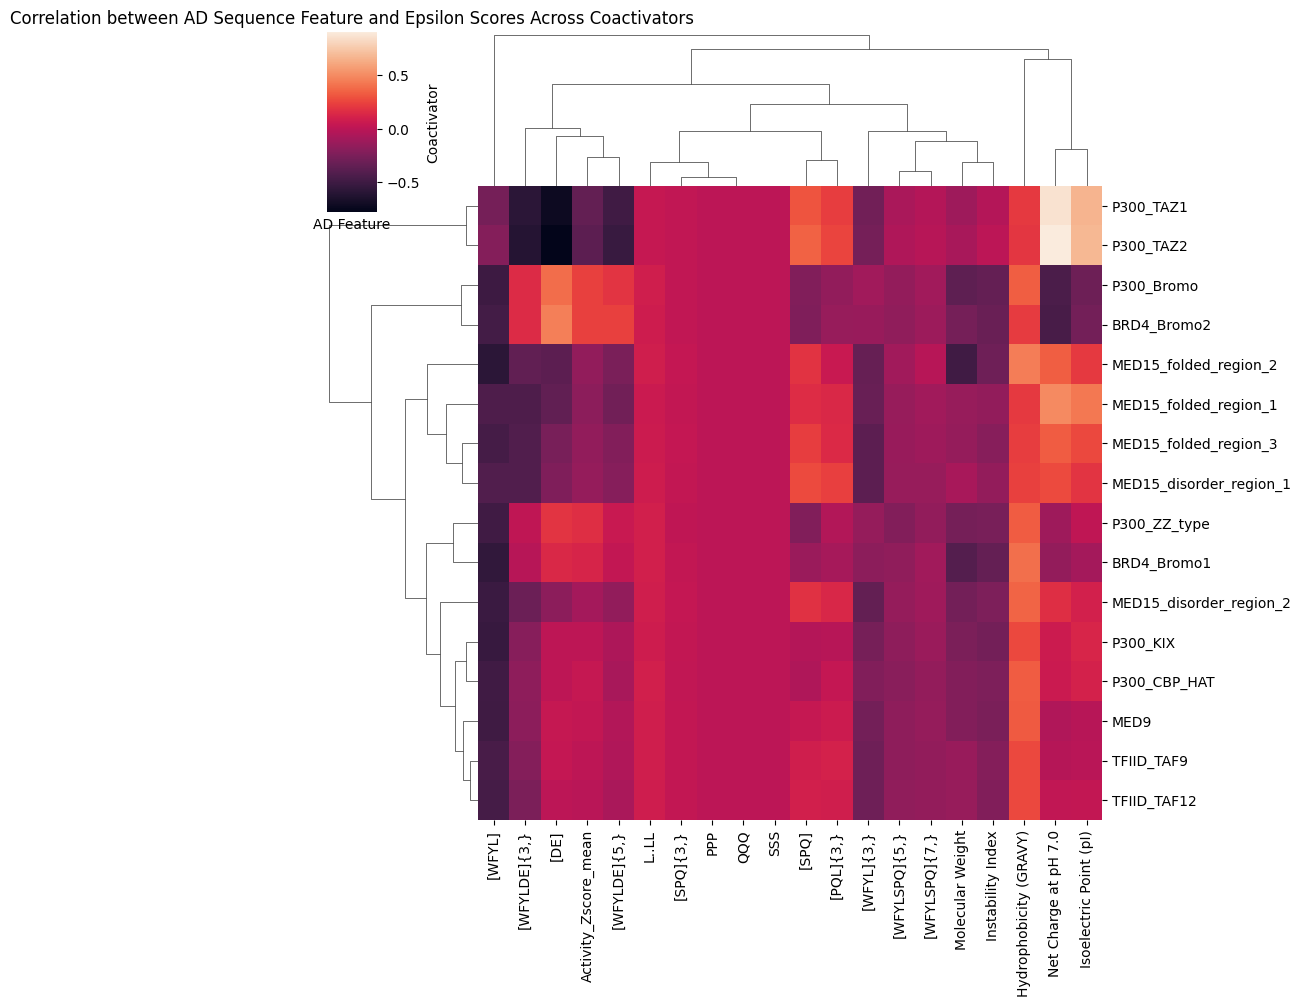

In [201]:
#Measure correlation between motifs and features vs e
motif_feat_e_corr = pd.DataFrame(columns=Staller5ADlib_select_features.columns.to_list()[1:])

for coA in coAs.index.to_list():
    coA_only = staller5libAD_coA_finches_activity[staller5libAD_coA_finches_activity["Prot2"] == coA].drop("Activity_Zscore_mean", axis=1)
    coA_with_AD_properties = coA_only.merge(Staller5ADlib_select_features, left_on="Prot1", right_index=True)
    r_vals = []
    for feature in Staller5ADlib_select_features.columns.to_list()[1:]:
        r, p = stat.pearsonr(coA_with_AD_properties[feature], coA_with_AD_properties["Total e (mf)"])
        r_vals.append(r)
    motif_feat_e_corr.loc[coA] = r_vals

sns.clustermap(motif_feat_e_corr.fillna(0))
plt.title("Correlation between AD Sequence Feature and Epsilon Scores Across Coactivators")
plt.xlabel("AD Feature")
plt.ylabel("Coactivator")

/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_53008/2382295950.py:10: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  metrics_df = df[sequence_col].apply(get_regex_counts).apply(pd.Series)
/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_53008/2382295950.py:27: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  metrics_df = df[sequence_col].apply(analyze_sequence).apply(pd.Series)


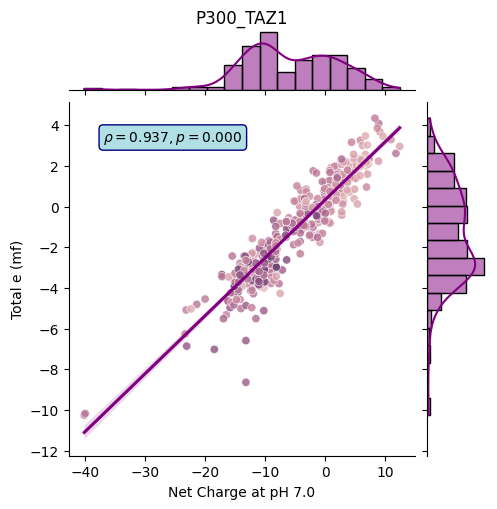

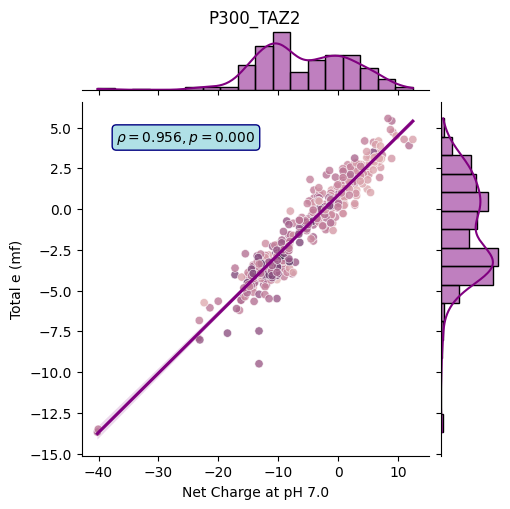

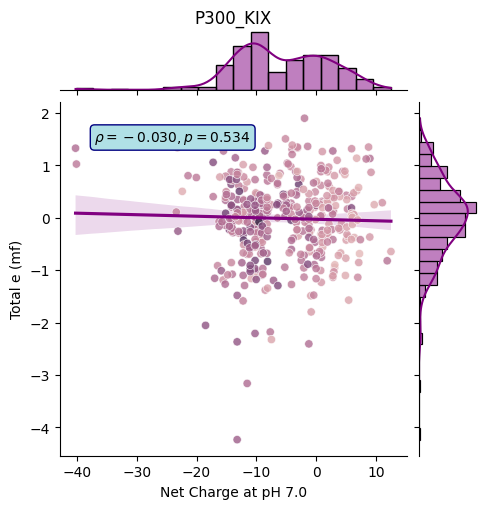

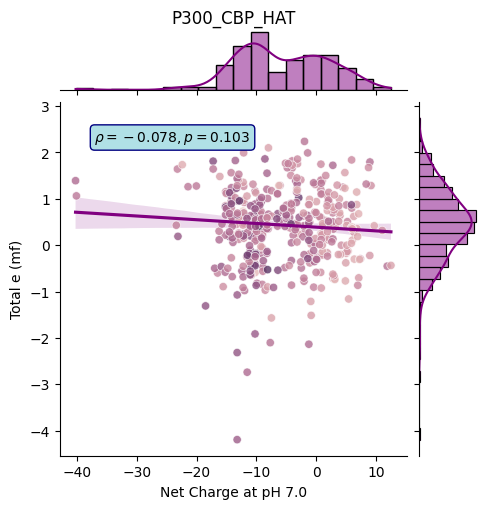

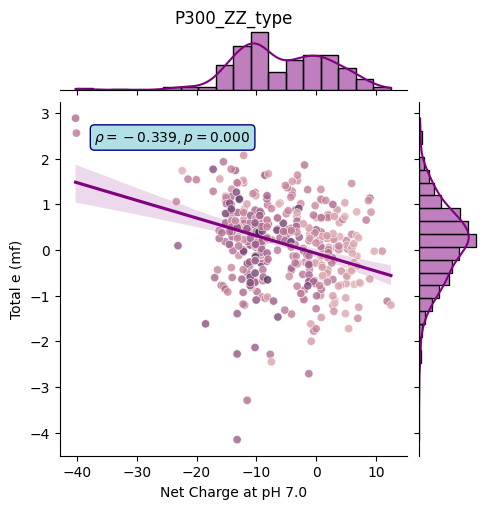

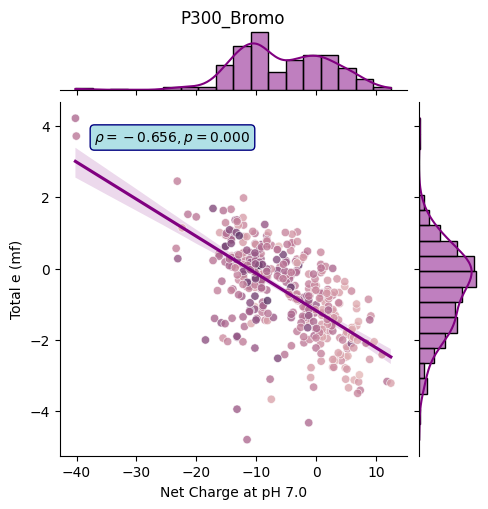

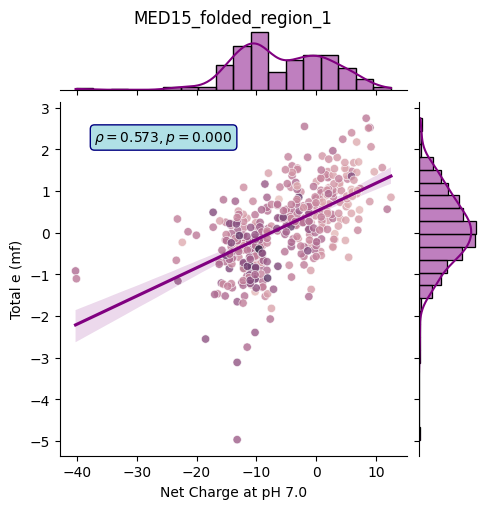

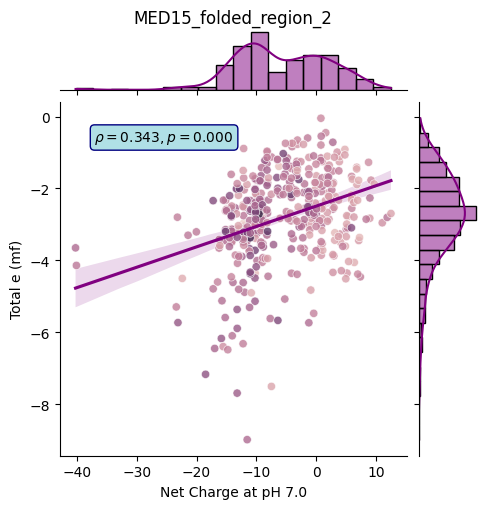

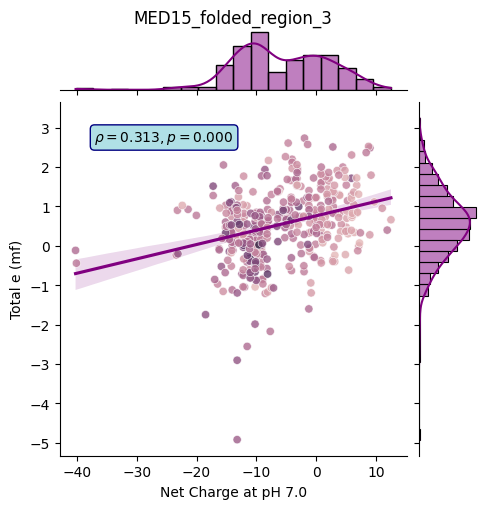

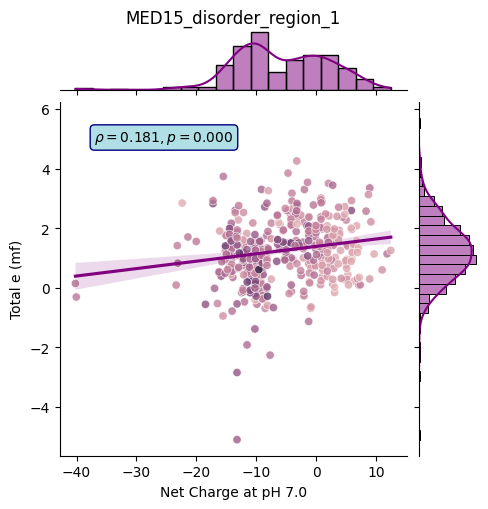

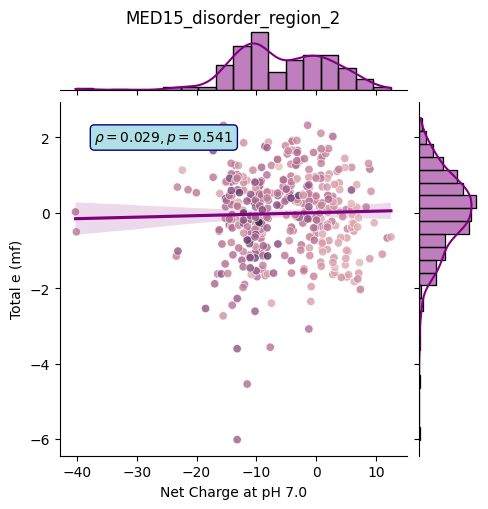

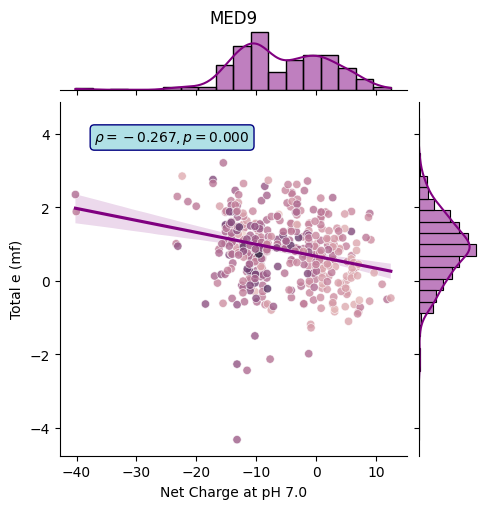

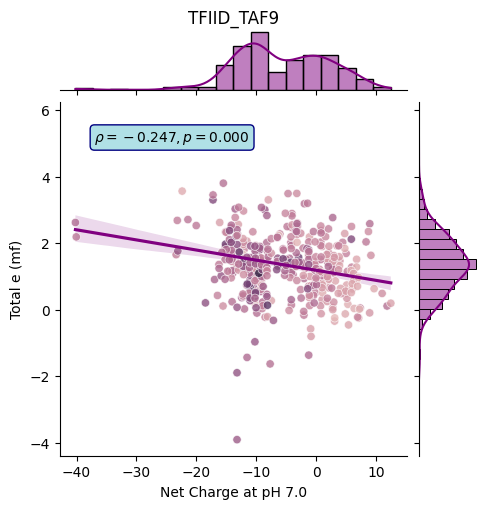

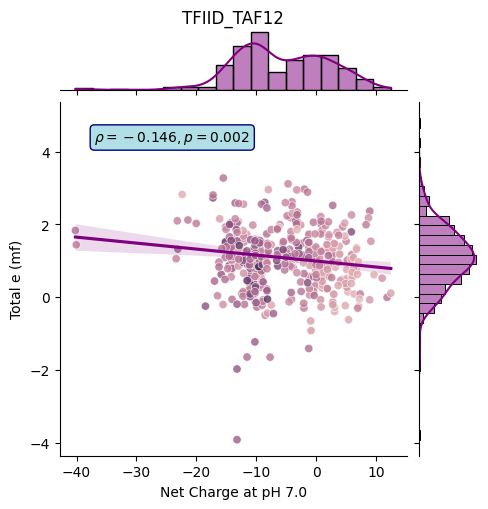

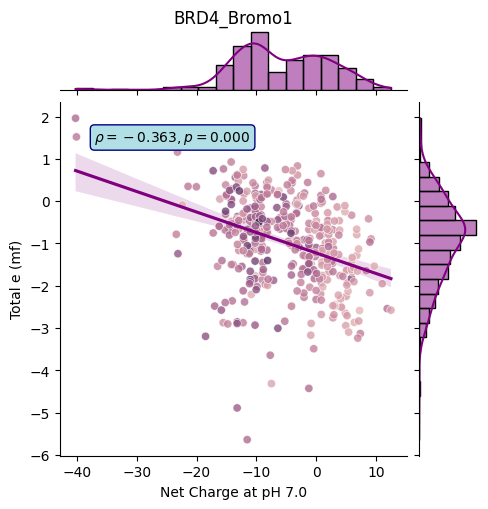

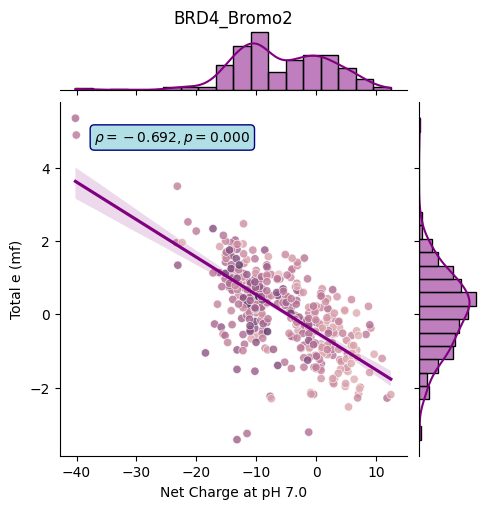

In [269]:
x = "Net Charge at pH 7.0"
y = "Total e (mf)"

df = stallerPredictedADs_coA_finches_activity
AD_seqs = Staller_predictedAD_select


AD_seq_features = compute_protein_metrics(count_patterns(AD_seqs))
for coA in coAs.index.to_list():
    coA_only = df[df["Prot2"] == coA]
    coA_with_AD_properties = coA_only.merge(AD_seq_features, left_on="Prot1", right_index=True)
    
    g = sns.jointplot(data = coA_with_AD_properties, x = x, y = y, kind='reg', scatter = False, color = "purple", height=5)
    ax_g_scatter = sns.scatterplot(data=coA_with_AD_properties, x = x, y = y, hue = "Activity_Zscore_mean_x", ax=g.ax_joint, alpha=0.8, legend=False)

    r, p = stat.pearsonr(coA_with_AD_properties[x], coA_with_AD_properties[y])
    g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
    
    plt.title(coA, y = 1.2)
    plt.savefig("figures/{0}_AD_charge_vs_e_predictedADs.png".format(coA), bbox_inches = "tight")
    plt.show()


In [160]:
binding_pivot = staller5libAD_coA_finches_activity.pivot(index = "Prot1", columns="Prot2", values="Total e (mf)")
activity_pivot = staller5libAD_coA_finches_activity.pivot(index = "Prot1", columns="Prot2", values="Activity_Zscore_mean")

<Axes: xlabel='Prot2', ylabel='Prot1'>

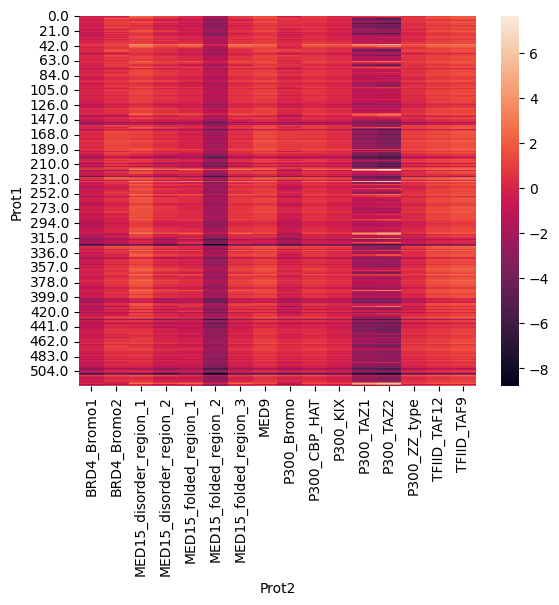

In [161]:
sns.heatmap(binding_pivot)

In [158]:
feature_var = "Net Charge at pH 7.0"

staller5lib_coA_charge = staller5libAD_coA_finches_activity[["Prot1", "Prot2", "Total e (mf)", "Activity_Zscore_mean"]].merge(coAS_features[[feature_var]], left_on="Prot2", right_index=True, how="left").rename({feature_var: "Coactivator " + feature_var}, axis=1)
staller5lib_coA_AD_charge = staller5lib_coA_charge.merge(Staller5ADlib_select_features[[feature_var]], left_on="Prot1", right_index=True, how="left").rename({feature_var: "AD " + feature_var}, axis=1)



,Prot1,Prot2,Total e (mf),Activity_Zscore_mean,Coactivator Net Charge at pH 7.0,AD Net Charge at pH 7.0
0,0.0,P300_TAZ1,0.623567,-0.569574,8.372995,-0.215025
1,1.0,P300_TAZ1,-1.414504,0.694728,8.372995,-7.200421
2,2.0,P300_TAZ1,-5.930522,-0.324962,8.372995,-22.200445
3,3.0,P300_TAZ1,-4.027382,-0.274816,8.372995,-16.207170
4,4.0,P300_TAZ1,-3.975393,2.004356,8.372995,-14.209656
...,...,...,...,...,...,...
520,520.0,BRD4_Bromo2,0.070172,-0.383847,-2.901124,2.405047
521,521.0,BRD4_Bromo2,-0.304229,-0.491240,-2.901124,12.386199
522,522.0,BRD4_Bromo2,-1.234596,-0.632829,-2.901124,2.410981
523,523.0,BRD4_Bromo2,-2.694882,-0.486277,-2.901124,12.397078


<Axes: xlabel='Coactivator Net Charge at pH 7.0', ylabel='AD Net Charge at pH 7.0'>

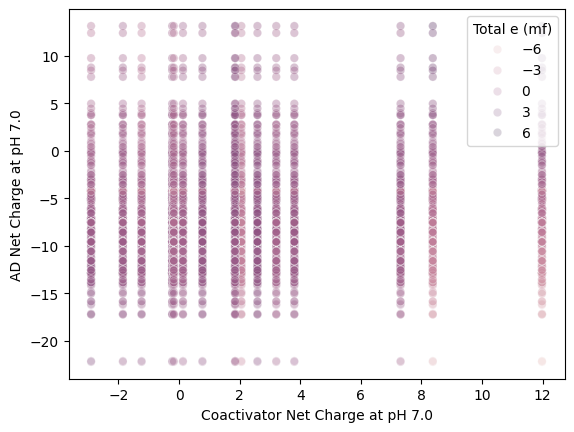

In [270]:
feature_var = "Net Charge at pH 7.0"

staller5lib_coA_charge = staller5libAD_coA_finches_activity[["Prot1", "Prot2", "Total e (mf)", "Activity_Zscore_mean"]].merge(coAS_features[[feature_var]], left_on="Prot2", right_index=True, how="left").rename({feature_var: "Coactivator " + feature_var}, axis=1)
staller5lib_coA_AD_charge = staller5lib_coA_charge.merge(Staller5ADlib_select_features[[feature_var]], left_on="Prot1", right_index=True, how="left").rename({feature_var: "AD " + feature_var}, axis=1)

x = "Coactivator " + feature_var
y = "AD " + feature_var

sns.scatterplot(staller5lib_coA_AD_charge, x = x, y = y, hue = "Total e (mf)", alpha = 0.2)

In [305]:
df = staller5libAD_coA_finches_activity
df_AD_select = Staller5ADlib_select

TAZ = df[[x in ["P300_TAZ1", "P300_TAZ2"] for x in df["Prot2"]]]
antiTAZ = TAZ[TAZ["Total e (mf)"] > 2][["Prot2", "Total e (mf)"]].merge(df_AD_select, left_index=True, right_index=True, how="left").drop("Prot2", axis=1).drop_duplicates()
allantiTAZ = df[[x in antiTAZ.index.to_list() for x in df["Prot1"]]]
allantiTazpivot = allantiTAZ.pivot(index = "Prot1", columns= "Prot2", values = "Total e (mf)")

antiTAZ_features = compute_protein_metrics(count_patterns(antiTAZ))

/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_53008/2382295950.py:10: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  metrics_df = df[sequence_col].apply(get_regex_counts).apply(pd.Series)
/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_53008/2382295950.py:27: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  metrics_df = df[sequence_col].apply(analyze_sequence).apply(pd.Series)


In [308]:
antiTAZ

,Total e (mf),Sequence,Activity_Zscore_mean
40,4.561714,KKKIDLPMKPRKLDKLMKFGKKGEGAEPKAGGKFEKLKFDMELKKE,-0.307225
40,5.373043,KKKIDLPMKPRKLDKLMKFGKKGEGAEPKAGGKFEKLKFDMELKKE,-0.307225
41,2.201890,KKKIDLPMKPRKLDKLMKFGKKGEGAEPSAGGQFESLTFDMELTSE,-0.258113
41,2.676509,KKKIDLPMKPRKLDKLMKFGKKGEGAEPSAGGQFESLTFDMELTSE,-0.258113
43,2.036262,KNKIDLPMKPRKLDKLMQFGNNGEGAEPKAGGQFEKLKFDMELKKE,-0.080004
43,2.599277,KNKIDLPMKPRKLDKLMQFGNNGEGAEPKAGGQFEKLKFDMELKKE,-0.080004
64,2.522362,PGLPKGLLKGDEDFKKIADMDFKALLKKIKK,-0.238905
64,3.010120,PGLPKGLLKGDEDFKKIADMDFKALLKKIKK,-0.238905
139,2.484211,PGLPNGLLSGKKKFSSIAKMKFSALLSQISS,-0.354519
139,3.235042,PGLPNGLLSGKKKFSSIAKMKFSALLSQISS,-0.354519


/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_53008/2382295950.py:10: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  metrics_df = df[sequence_col].apply(get_regex_counts).apply(pd.Series)


<Axes: >

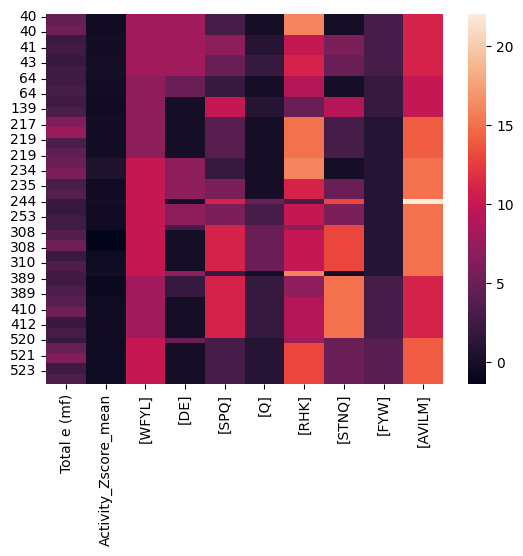

In [307]:
sns.heatmap(count_patterns(antiTAZ).drop("Sequence", axis=1))

<Axes: xlabel='Prot2', ylabel='Prot1'>

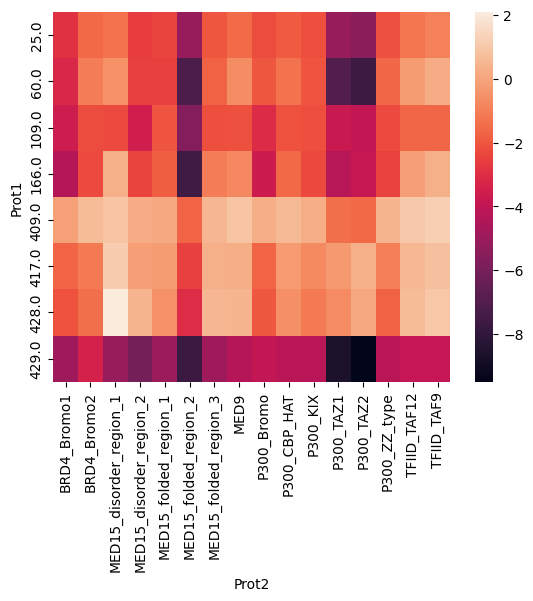

In [ ]:
#KIX binding ADs
df = stallerP53AD_coA_finches_activity
df_AD_select = Stallerp53AD_select

KIX = df[df["Prot2"] == "P300_KIX"]
KIX_binding_ADs = KIX[KIX["Total e (mf)"] < -2][["Prot2", "Total e (mf)"]].merge(df_AD_select, left_index=True, right_index=True, how="left")
allKIXbinding = df[[x in KIX_binding_ADs.index.to_list() for x in df["Prot1"]]]
sns.heatmap(allKIXbinding.pivot(index = "Prot1", columns= "Prot2", values = "Total e (mf)"))

<Axes: xlabel='Prot2', ylabel='Prot1'>

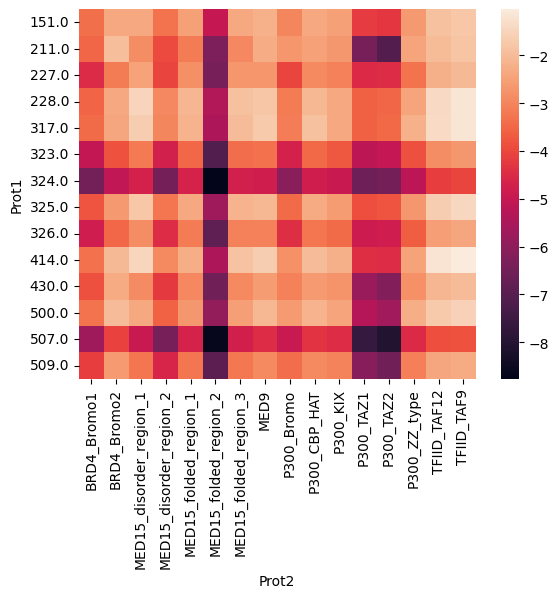

In [ ]:
#Charge of coA vs charge of AD vs epsilon




In [385]:
#combine all ADs
def pivot_activity_df(finchesdf, activitydf, dfname):
    pivotdf = finchesdf.pivot(index = "Prot1", columns="Prot2", values="Total e (mf)")
    pivotdf.index = [dfname + "_" + str(int(x)) for x in pivotdf.index.to_list()]
    activitydf_output = activitydf[["Activity_Zscore_mean"]]
    activitydf_output.index = [dfname + "_" + str(int(x)) for x in activitydf.index.to_list()]
    return pivotdf, activitydf_output

staller5lib_pivot, staller5lib_activity = pivot_activity_df(staller5libAD_coA_finches_activity, Staller5ADlib_select, "Staller5Lib")
stallerP53AD_pivot, stallerP53_activity = pivot_activity_df(stallerP53AD_coA_finches_activity, stallerP53AD_coA_finches_activity[["Prot1", "Activity_Zscore_mean"]].groupby("Prot1").agg(np.mean), "StallerP53")
stallerPredicted_pivot, stallerPredicted_activity = pivot_activity_df(stallerPredictedADs_coA_finches_activity, Staller_predictedAD_select, "StallerPredicted")

all_AD_coA = pd.concat(
    [staller5lib_pivot,
    stallerP53AD_pivot,
    stallerPredicted_pivot
    ])

all_AD_coA_activity = pd.concat([
    staller5lib_activity,
    stallerP53_activity,
    stallerPredicted_activity
    ])

#dropna_activity
all_AD_coA_activity_dropna = all_AD_coA_activity["Activity_Zscore_mean"].dropna()
all_AD_coA_dropna = all_AD_coA.loc[all_AD_coA_activity_dropna.index]

stallerPredicted_activity_dropna = stallerPredicted_activity["Activity_Zscore_mean"].dropna()
stallerPredicted_pivot_dropna = stallerPredicted_pivot.loc[stallerPredicted_activity_dropna.index]

stallerP53_activity_dropna = stallerP53_activity["Activity_Zscore_mean"].dropna()
stallerP53AD_pivot_dropna = stallerP53AD_pivot.loc[stallerP53_activity_dropna.index]

print(len(stallerP53_activity_dropna), len(stallerP53AD_pivot_dropna))




440 440


/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_42817/447237728.py:10: FutureWarning: The provided callable <function mean at 0x11240eac0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  stallerP53AD_pivot, stallerP53_activity = pivot_activity_df(stallerP53AD_coA_finches_activity, stallerP53AD_coA_finches_activity[["Prot1", "Activity_Zscore_mean"]].groupby("Prot1").agg(np.mean), "StallerP53")


---
# Running models

In [382]:
selected_features = staller5lib_pivot[["MED15_folded_region_2", "P300_TAZ1", "P300_TAZ2"]]

In [383]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

0.29516714346312645


<Axes: >

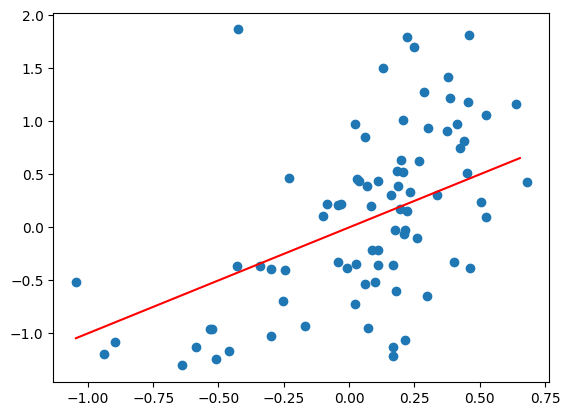

In [388]:
X_train, X_test, y_train, y_test = train_test_split(stallerPredicted_pivot_dropna, stallerPredicted_activity_dropna, test_size=0.2, random_state=42)

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel,
        random_state=0).fit(X_train, y_train)

score = gpr.score(X_test, y_test)
print(score)

y_pred = gpr.predict(X_test)

plt.scatter(x = y_pred, y = y_test)
sns.lineplot(x = np.arange(min(y_pred), max(y_pred), 0.05), y = np.arange(min(y_pred), max(y_pred), 0.05), color="red")

0.4755220185172789
0.29638509885036834


<Axes: >

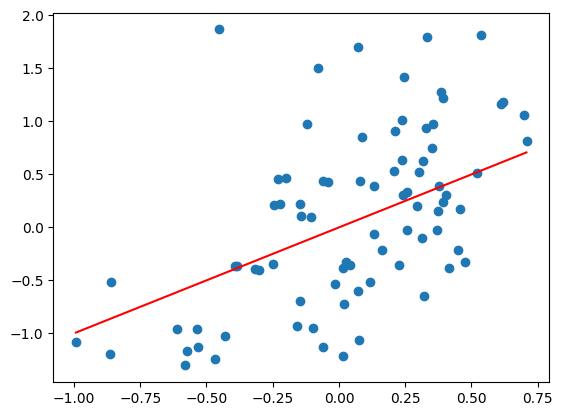

In [389]:
X_train, X_test, y_train, y_test = train_test_split(stallerPredicted_pivot_dropna, stallerPredicted_activity_dropna, test_size=0.2, random_state=42)

# 4️⃣ Train the Linear Regression model on polynomial features
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(mse)
r2 = r2_score(y_test, y_pred)
print(r2)

plt.scatter(x = y_pred, y = y_test)
sns.lineplot(x = np.arange(min(y_pred), max(y_pred), 0.05), y = np.arange(min(y_pred), max(y_pred), 0.05), color="red")

In [361]:
#Clustering based on similarity across domains
def pivot_cluster(AD_coA_finchesdf, ADlibdf, plot, name):
    pivotdf = AD_coA_finchesdf.pivot(index="Prot1", columns="Prot2", values="Total e (mf)")
    kmeans = AgglomerativeClustering(n_clusters=10)
    pca = PCA(2) 
    clusterpred = kmeans.fit_predict(pivotdf)
    PCA_vals = pca.fit_transform(pivotdf)

    cluster_PCA_df = ADlibdf.copy()
    cluster_PCA_df[["PCA 1", "PCA 2"]] = PCA_vals
    cluster_PCA_df["Cluster"] = clusterpred

    if plot:
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
        plt.title(name)
        ax1 = sns.boxplot(cluster_PCA_df, x = "Cluster", y = "Activity_Zscore_mean", ax = ax1)
        ax2 = sns.scatterplot(cluster_PCA_df, x = "PCA 1", y = "PCA 2", hue = "Cluster", alpha=0.5, ax = ax2)
        plt.show()

    return pivotdf, cluster_PCA_df

In [ ]:

pca = PCA(2) 
PCA_vals = pca.fit_transform(staller5libAD_coA_finches_activity)

cluster_PCA_df = Staller5ADlib_select.copy()
cluster_PCA_df[["PCA 1", "PCA 2"]] = PCA_vals

sns.scatterplot(cluster_PCA_df, x = "PCA 1", y = "PCA 2")

ValueError: could not convert string to float: 'P300_TAZ1'

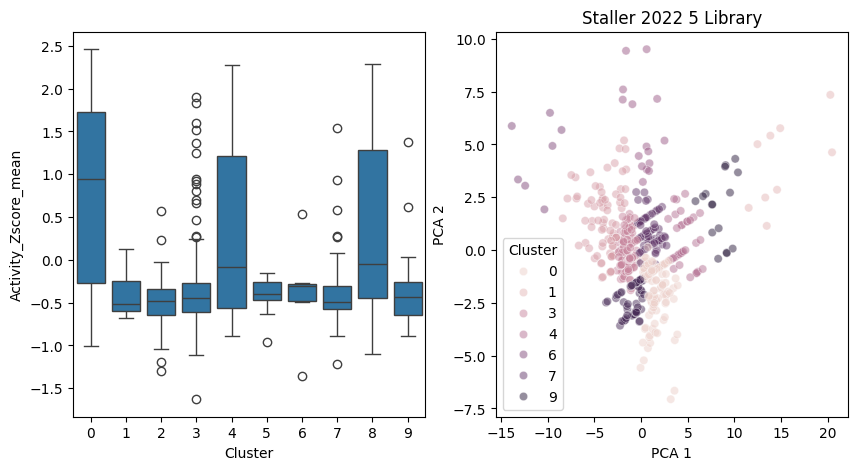

/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_42817/3417607001.py:2: FutureWarning: The provided callable <function mean at 0x11240eac0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  stallerP53_pivotdf, stallerP53_cluster_PCA_df = pivot_cluster(stallerP53AD_coA_finches_activity, stallerP53AD_coA_finches_activity[["Prot1", "Activity_Zscore_mean"]].groupby("Prot1").agg(np.mean), "Staller 2022 P53 Library")


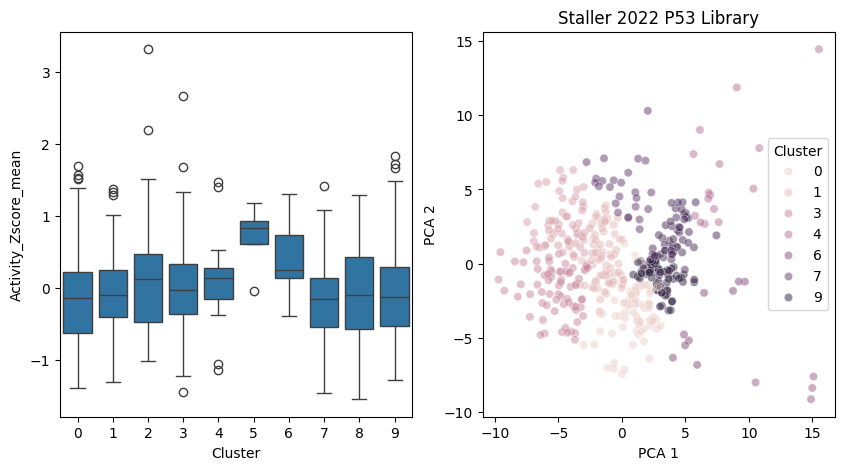

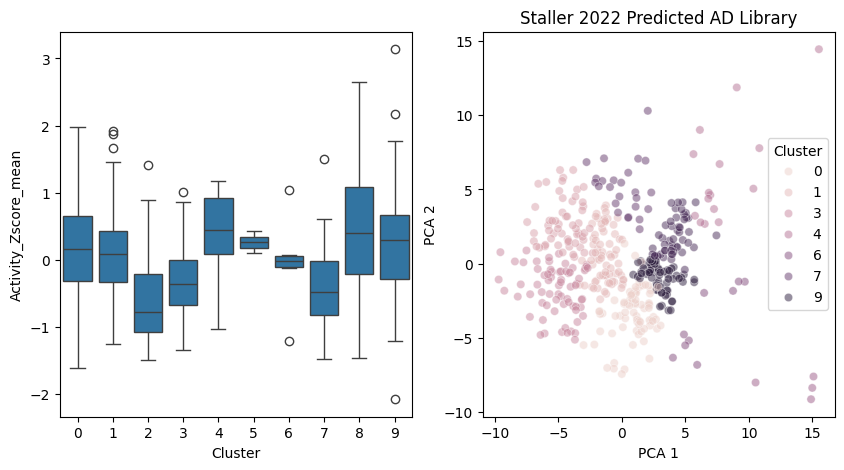

ValueError: Length of values (489) does not match length of index (7824)

In [257]:
staller5lib_pivotdf, staller5lib_cluster_PCA_df = pivot_cluster(staller5libAD_coA_finches_activity, Staller5ADlib_select, "Staller 2022 5 Library")
stallerP53_pivotdf, stallerP53_cluster_PCA_df = pivot_cluster(stallerP53AD_coA_finches_activity, stallerP53AD_coA_finches_activity[["Prot1", "Activity_Zscore_mean"]].groupby("Prot1").agg(np.mean), "Staller 2022 P53 Library")
stallerPredicted_pivotdf, stallerPredicted_cluster_PCA_df = pivot_cluster(stallerPredictedADs_coA_finches_activity, Staller_predictedAD_select, "Staller 2022 Predicted AD Library")
choi_pivotdf, choi_cluster_PCA_df = pivot_cluster(choiAD_coA_finches_activity, choiAD_coA_finches, "Choi 2000 ADs")

In [159]:
#most interacting ADs
attractiveADs = staller5libAD_coA_finches_activity[["Prot1", "Prot2", "Attractive e (mf)"]].sort_values("Attractive e (mf)")[:3000].groupby("Prot1").agg(list)
attractiveADs["Mean Attractive e"] = [np.mean(x) for x in attractiveADs["Attractive e (mf)"]]
attractiveADs["Num CoAs"] = [len(x) for x in attractiveADs["Prot2"]]
attractiveADs = attractiveADs.sort_values("Mean Attractive e")
attractiveADs = attractiveADs.merge(Staller5ADlib.loc[attractiveADs.index.to_list()][["Activity_Zscore_mean"]], left_index=True, right_index=True)

<Axes: xlabel='Mean Attractive e', ylabel='Activity_Zscore_mean'>

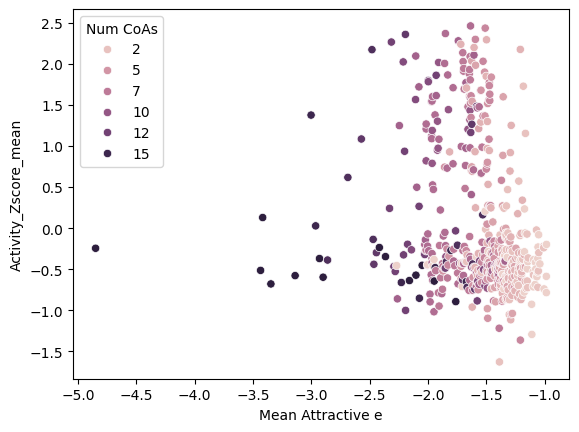

In [160]:
sns.scatterplot(attractiveADs, x = "Mean Attractive e", y = "Activity_Zscore_mean", hue = "Num CoAs")

507   -0.244741
211    0.129276
509   -0.513943
207    0.240891
68    -0.263593
         ...   
388   -0.510817
261    1.837621
463    1.211258
460   -0.477238
121   -0.636957
Name: Activity_Zscore_mean, Length: 305, dtype: float64

In [130]:
Staller5ADlib.loc[attractiveADs.index.to_list()[:20]]

,ADseq,Variant_Name,SystematicName,Activity_Mean_MSS18,Activity_std_MSS18,Biological_Replicate_1_Activity,Biological_Replicate_2_Activity,Biological_Replicate_3_Activity,Biological_Replicate_4_Activity,8_Bin_sort,...,PerturbCharge,PerturbAromatics,CITED2,Stat3,Hif1alpha,p65_L2Y,p65,VP16 H1,CorrectedPvalues_FDR_5percent,SigDiffFromWT
507,TDFWDEEWWMSWWWEMGWDRWKEWPEWWWGQNEFDFMTD,IVL>W,"I223W,V227W,L228W,L231W,V232W,I233W,L237W,I240...",2632.022786,476.231802,2988.395436,2599.731607,1957.857806,2488.222802,2211.067712,...,False,True,True,False,False,False,False,False,0.000176277,TRUE
211,PTDWSWGDEWHWDGEDWAMAHADAWDDFDWDMWGDGDSP,IVL>W,"V418W,L420W,L424W,L426W,V431W,L439W,L444W,L447W",3007.922792,278.144478,2807.872663,3071.432023,2165.688264,3338.638132,2741.144312,...,False,True,False,False,False,False,False,True,0.007015823,TRUE
509,TDFYDEEYYMSYYYEMGYDRYKEYPEYWYGQNEFDFMTD,IVL>Y,"I223Y,V227Y,L228Y,L231Y,V232Y,I233Y,L237Y,I240...",2450.796761,711.539476,3103.285348,1929.674667,2159.864327,1879.808137,2266.512758,...,False,True,True,False,False,False,False,False,0.00177824,TRUE
207,PTDVSLGDEWHLDGEDFDMAHADALDDFDFDMLGDGDSP,supercharge3,"L424W,V431F,A432D,L444F",3353.666919,638.458403,2788.773346,3367.836608,2722.907629,2824.095362,4149.883085,...,False,False,False,False,False,False,False,True,0.011505106,TRUE
68,PGLPNGLLDGDEDFDDIADMDFDALLDQIDD,ST>D,"S529D,S535D,S536D,S543D,S547D,S550D,S551D",2852.467088,445.426992,2245.565518,2628.155432,2343.442165,2703.619373,3426.714385,...,True,False,False,False,False,False,True,False,0.839807296,FALSE
70,PGLPNGLLEGDEDFEEIADMDFEALLEQIEE,ST>E,"S529E,S535E,S536E,S543E,S547E,S550E,S551E",2489.210379,647.010302,3150.788093,2170.808960,1861.298391,2631.430483,1716.887402,...,True,False,False,False,False,False,True,False,0.858045362,FALSE
174,PTDVSLGDELHLDGEDFDMAHFDALDDFDLDMLGDGDSP,supercharge2,"V431F,A432D,A436F",4469.388294,449.010543,3915.154497,4585.430694,3749.320073,4243.221862,4938.975776,...,False,False,False,False,False,False,False,True,0.986528233,FALSE
197,PTDVSLGDELHLDGEDVFFFHFDFLDDFDLDFLGDGDSP,MA>F,"A432F,M433F,A434F,A436F,A438F,M446F",2688.469521,276.408263,2628.609468,2385.618546,2123.678402,2708.461336,2681.141284,...,False,True,False,False,False,False,False,True,0.001449163,TRUE
15,EEEIDLPMEPRELDELMEFGEEGEGAEPEAGGEFEELEFDMELEEE,STQN>E,"S719E,N720E,T721E,S727E,T730E,S733E,Q736E,N739...",2115.230700,945.827948,2992.693649,1470.636777,1681.427256,1177.290150,2339.267099,...,True,False,False,True,False,False,False,False,0.884721242,FALSE
201,PTDVSLGDELHLDGEDVYMYHYDYLDDFDLDMLGDGDSP,A>Y,"A432Y,A434Y,A436Y,A438Y",5383.601973,877.253773,5210.943597,4581.386667,4715.243815,4918.653630,6576.943590,...,False,True,False,False,False,False,False,True,0.030564925,FALSE


In [114]:
#Get top 100 binding ADs from each domain
domain = "P300_TAZ1"
df = staller5libAD_coA_finches_activity.copy()
topnumber = 30

domain_sorted_interaction = df[df["Prot2"] == domain].sort_values("Attractive e", ascending = True)
top_ADs = domain_sorted_interaction["Prot1"][:topnumber]


SyntaxError: invalid syntax (91133129.py, line 2)

In [ ]:
#Can we map interaction strength between AD and CoA to sequence features of the CoA?


In [71]:
ax = sns.kdeplot(staller5libAD_coA_finches_activity, x = "Total e (mf)", y = "Activity_Mean_MSS18", hue = "Prot2", alpha=0.5)


ValueError: Could not interpret value `Activity_Mean_MSS18` for `y`. An entry with this name does not appear in `data`.